In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import cluster, pairwise_distances
from sklearn.manifold import TSNE

from tqdm import tqdm

from FlagRep0 import truncate_svd, chordal_distance
from FlagRep import FlagRep

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score

import pandas as pd


In [2]:
def set_seed(seed):
    np.random.seed(seed)                   
    torch.manual_seed(seed)                
    torch.cuda.manual_seed(seed)           
    torch.cuda.manual_seed_all(seed)       
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False  

set_seed(42)


In [9]:


def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs


# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        # Input layer to hidden layer 1
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Hidden layer 1 to hidden layer 2
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer 2 to hidden layer 3
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer 3 to output layer (10 classes)
        self.fc4 = nn.Linear(hidden_size, output_size)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation on the output (for logits)
        return x

In [10]:

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)



In [11]:
# Set up hyperparameters
input_size = 28 * 28  # Flattened image size
hidden_size = 128     # Same size for all hidden layers
output_size = 10      # 10 output classes (digits 0-9)
num_epochs = 10
learning_rate = 0.001


n_shots = 10

In [12]:
# # Define the neural network
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(NeuralNetwork, self).__init__()
#         # Input layer to hidden layer 1
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         # Hidden layer 1 to hidden layer 2
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         # Hidden layer 2 to hidden layer 3
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         # Hidden layer 3 to hidden layer 4
#         self.fc4 = nn.Linear(hidden_size, hidden_size)
#         # Hidden layer 4 to output layer (10 classes)
#         self.fc5 = nn.Linear(hidden_size, output_size)
#         # Activation function
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.relu(self.fc4(x))
#         x = self.fc5(x)  # No activation on the output (for logits)
#         return x




# # Initialize the model, loss function, and optimizer
# model = NeuralNetwork(input_size, hidden_size, output_size)
# criterion = nn.CrossEntropyLoss()  # For multi-class classification
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training the model
# for epoch in range(num_epochs):
#     for images, labels in train_loader:
#         # Flatten the images from (batch_size, 1, 28, 28) to (batch_size, 28*28)
#         images = images.view(-1, 28*28)

#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Testing the model
# model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
# correct = 0
# total = 0

# with torch.no_grad():
#     for images, labels in test_loader:
#         images = images.view(-1, 28*28)  # Flatten images
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# accuracy = 100 * correct / total
# print(f'Test Accuracy: {accuracy:.2f}%')


In [13]:
# results = pd.DataFrame(columns = ['Method', 'Accuracy'])

# for seed0 in range(5):
#     np.random.seed(seed0)

#     shot_ids = []
#     train_lbls = np.array([lbl for _, lbl in train_dataset])
#     train_dta = [img for img,_ in train_dataset] #bad coding
#     for l in np.unique(train_lbls):
#         idx = np.where(train_lbls == l)[0]
#         idxc = np.random.choice(idx, n_shots,replace = False)
#         shot_ids.append(idxc)



#     shot_dict = {}
#     euc_shot_dict = {}
#     for i, s in enumerate(shot_ids):
#         hidden_rep0s = []
#         hidden_rep1s = []
#         euc_shot_dict[i] = np.zeros((128,1))
#         for img in [train_dta[si] for si in s]:
#             sample_image = img.view(-1, 28*28)
#             with torch.no_grad():
#                 # Step-by-step pass through each layer
#                 h10 = model.fc1(sample_image)
#                 h11 = model.relu(h10)  # Pass through first hidden layer
#                 h20 = model.fc2(h11)
#                 h21 = model.relu(h20)         # Pass through second hidden layer
#                 h30 = model.fc3(h21)
#                 h31 = model.relu(h30)         # Pass through third hidden layer
#                 h40 = model.fc3(h31)
#                 h41 = model.relu(h40)         # Pass through third hidden layer

#                 # hidden_rep0 = np.hstack([h.cpu().detach().numpy().T for h in [h31,h30]])
#                 # hidden_rep1 = np.hstack([h.cpu().detach().numpy().T for h in [h21,h20]])
#                 hidden_rep0 = h31.cpu().detach().numpy().T
#                 hidden_rep1 = h41.cpu().detach().numpy().T
                
#                 hidden_rep0s.append(hidden_rep0)
#                 hidden_rep1s.append(hidden_rep1)
#                 euc_shot_dict[i] += h31.cpu().detach().numpy().T

#         shot_dict[i] = np.hstack([np.hstack(hidden_rep0s),np.hstack(hidden_rep1s)])
#         euc_shot_dict[i] = euc_shot_dict[i]/n_shots


#     shot_flags = {}
#     shot_flags['FlagRep'] = []
#     shot_flags['QR'] = []
#     shot_flags['SVD'] = []
#     for lbl, m in shot_dict.items():
#         # my_flag_rep = FlagRep( [np.arange(2*n_shots), np.arange(4*n_shots)],
#                             # flag_type=[1,2])
#         my_flag_rep = FlagRep( [np.arange(n_shots), np.arange(2*n_shots)],
#                             flag_type=[1,2])
#         frep = my_flag_rep.fit_transform(m)
#         shot_flags['FlagRep'].append(frep)

#         q, _ = np.linalg.qr(m)
#         shot_flags['QR'].append(q[:,:2])

#         u = truncate_svd(m)
#         shot_flags['SVD'].append(u[:,:2])
                


#     # Pass the sample through the network step-by-step without computing gradients
#     test_mats = []
#     euc_test = []
#     for img,_ in test_dataset:
#         sample_image = img.view(-1, 28*28)
#         with torch.no_grad():
#             # Step-by-step pass through each layer
#             h10 = model.fc1(sample_image)
#             h11 = model.relu(h10)  # Pass through first hidden layer
#             h20 = model.fc2(h11)
#             h21 = model.relu(h20)  # Pass through second hidden layer
#             h30 = model.fc3(h21)
#             h31 = model.relu(h30)  # Pass through third hidden layer

#             # hidden_rep = [h.cpu().detach().numpy().T for h in [h10,h11,h20,h21,h30,h31]]
#             # hidden_rep = [h.cpu().detach().numpy().T for h in [h31,h30,h21,h20]]
#             hidden_rep = [h.cpu().detach().numpy().T for h in [h31,h21]]
#         test_mats.append(np.hstack(hidden_rep))
#         euc_test.append(h31.cpu().detach().numpy().T)


#     flags = {}
#     flags['FlagRep'] = []
#     flags['QR'] = []
#     flags['SVD'] = []

#     for m in tqdm(test_mats):
#         # my_flag_rep = FlagRep( [np.arange(2),np.arange(4)], 
#                             # flag_type=[1,2])
#         my_flag_rep = FlagRep( [np.arange(1),np.arange(2)], 
#                             flag_type=[1,2])
#         frep = my_flag_rep.fit_transform(m)
#         flags['FlagRep'].append(frep)

#         q, _ = np.linalg.qr(m)
#         flags['QR'].append(q[:,:2])

#         u = truncate_svd(m)
#         flags['SVD'].append(u[:,:2])


#     Bs = make_Bs([1,2])

#     dist_mats = {}
#     for method_name in ['FlagRep', 'QR', 'SVD']:
#         dist_mats[method_name] = np.zeros((10,len(flags[method_name])))
#         for i, shot_flag in enumerate(shot_flags[method_name]):
#             for j, flag in enumerate(flags[method_name]):
#                 dist_mats[method_name][i,j] = chordal_distance(shot_flag, flag, Bs, Bs)

# dist_mats['Euclidean'] = np.zeros((10,len(euc_test)))
# for i, shot in euc_shot_dict.items():
#     for j, pt in enumerate(euc_test):
#         dist_mats['Euclidean'][i,j] = np.linalg.norm(shot.T - pt.T)


#     for method_name in ['FlagRep', 'QR', 'SVD', 'Euclidean']:
#         test_preds = np.argmin(dist_mats[method_name], axis = 0)
#         test_labels = [lbl for _, lbl in test_dataset]
#         acc = accuracy_score(test_labels, test_preds)
#         row = pd.DataFrame(columns = results.columns,
#                         data = [[method_name, acc]])
#         results = pd.concat([results, row])

#         #print(results)
#         #     print()
#         #     print(method_name)
#         #     print()

#         # print()
#         # print()


In [14]:
results = pd.DataFrame(columns = ['Method', 'Accuracy'])

for seed0 in range(5):
    np.random.seed(seed0)
    for m_num in range(5):
        # Initialize the model, loss function, and optimizer
        model = NeuralNetwork(input_size, hidden_size, output_size)
        model.load_state_dict(torch.load(f'../models/mnist_model{m_num}.pth'))


        shot_ids = []
        train_lbls = np.array([lbl for _, lbl in train_dataset])
        train_dta = [img for img,_ in train_dataset] #bad coding
        for l in np.unique(train_lbls):
            idx = np.where(train_lbls == l)[0]
            idxc = np.random.choice(idx, n_shots,replace = False)
            shot_ids.append(idxc)



        shot_dict = {}
        euc_shot_dict = {}
        for i, s in enumerate(shot_ids):
            hidden_rep0s = []
            hidden_rep1s = []
            euc_shot_dict[i] = np.zeros((128,1))
            for img in [train_dta[si] for si in s]:
                sample_image = img.view(-1, 28*28)
                with torch.no_grad():
                    # Step-by-step pass through each layer
                    h10 = model.fc1(sample_image)
                    h11 = model.relu(h10)  # Pass through first hidden layer
                    h20 = model.fc2(h11)
                    h21 = model.relu(h20)         # Pass through second hidden layer
                    h30 = model.fc3(h21)
                    h31 = model.relu(h30)         # Pass through third hidden layer

                    # hidden_rep0 = np.hstack([h.cpu().detach().numpy().T for h in [h31,h30]])
                    # hidden_rep1 = np.hstack([h.cpu().detach().numpy().T for h in [h21,h20]])
                    hidden_rep0 = h31.cpu().detach().numpy().T
                    hidden_rep1 = h21.cpu().detach().numpy().T
                    
                    hidden_rep0s.append(hidden_rep0)
                    hidden_rep1s.append(hidden_rep1)
                    euc_shot_dict[i] += h31.cpu().detach().numpy().T

            shot_dict[i] = np.hstack([np.hstack(hidden_rep0s),np.hstack(hidden_rep1s)])
            euc_shot_dict[i] = euc_shot_dict[i]/n_shots


        shot_flags = {}
        shot_flags['FlagRep'] = []
        shot_flags['QR'] = []
        shot_flags['SVD'] = []
        for lbl, m in shot_dict.items():
            # my_flag_rep = FlagRep( [np.arange(2*n_shots), np.arange(4*n_shots)],
                                # flag_type=[1,2])
            my_flag_rep = FlagRep( [np.arange(n_shots), np.arange(2*n_shots)],
                                flag_type=[1,2])
            frep = my_flag_rep.fit_transform(m)
            shot_flags['FlagRep'].append(frep)

            q, _ = np.linalg.qr(m)
            shot_flags['QR'].append(q[:,:2])

            u = truncate_svd(m)
            shot_flags['SVD'].append(u[:,:2])
                


        # Pass the sample through the network step-by-step without computing gradients
        test_mats = []
        euc_test = []
        for img,_ in test_dataset:
            sample_image = img.view(-1, 28*28)
            with torch.no_grad():
                # Step-by-step pass through each layer
                h10 = model.fc1(sample_image)
                h11 = model.relu(h10)  # Pass through first hidden layer
                h20 = model.fc2(h11)
                h21 = model.relu(h20)  # Pass through second hidden layer
                h30 = model.fc3(h21)
                h31 = model.relu(h30)  # Pass through third hidden layer

                # hidden_rep = [h.cpu().detach().numpy().T for h in [h10,h11,h20,h21,h30,h31]]
                # hidden_rep = [h.cpu().detach().numpy().T for h in [h31,h30,h21,h20]]
                hidden_rep = [h.cpu().detach().numpy().T for h in [h31,h21]]
            test_mats.append(np.hstack(hidden_rep))
            euc_test.append(h31.cpu().detach().numpy().T)


        flags = {}
        flags['FlagRep'] = []
        flags['QR'] = []
        flags['SVD'] = []

        for m in tqdm(test_mats):
            # my_flag_rep = FlagRep( [np.arange(2),np.arange(4)], 
                                # flag_type=[1,2])
            my_flag_rep = FlagRep( [np.arange(1),np.arange(2)], 
                                flag_type=[1,2])
            frep = my_flag_rep.fit_transform(m)
            flags['FlagRep'].append(frep)

            q, _ = np.linalg.qr(m)
            flags['QR'].append(q[:,:2])

            u = truncate_svd(m)
            flags['SVD'].append(u[:,:2])


        Bs = make_Bs([1,2])

        dist_mats = {}
        for method_name in ['FlagRep', 'QR', 'SVD']:
            dist_mats[method_name] = np.zeros((10,len(flags[method_name])))
            for i, shot_flag in enumerate(shot_flags[method_name]):
                for j, flag in enumerate(flags[method_name]):
                    dist_mats[method_name][i,j] = chordal_distance(shot_flag, flag, Bs, Bs)

        dist_mats['Euclidean'] = np.zeros((10,len(euc_test)))
        for i, shot in euc_shot_dict.items():
            for j, pt in enumerate(euc_test):
                dist_mats['Euclidean'][i,j] = np.linalg.norm(shot.T - pt.T)


        for method_name in ['FlagRep', 'QR', 'SVD', 'Euclidean']:
            test_preds = np.argmin(dist_mats[method_name], axis = 0)
            test_labels = [lbl for _, lbl in test_dataset]
            acc = accuracy_score(test_labels, test_preds)
            row = pd.DataFrame(columns = results.columns,
                            data = [[method_name, acc]])
            results = pd.concat([results, row])

        #print(results)
        #     print()
        #     print(method_name)
        #     print()

        # print()
        # print()


100%|██████████| 10000/10000 [00:07<00:00, 1422.14it/s]
/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_29458/2441449260.py:133: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row])
100%|██████████| 10000/10000 [00:11<00:00, 905.80it/s]


<Axes: xlabel='Number Shots', ylabel='Accuracy'>

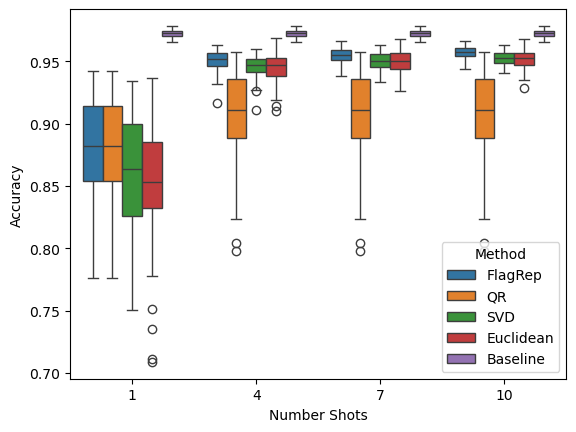

In [2]:
import seaborn as sns
import pandas as pd

results = pd.read_csv('../results/mnist_fewshot_idea.csv', index_col = 0)

sns.boxplot(results, hue = 'Method', y = 'Accuracy', x = 'Number Shots')

In [10]:
results

,Method,Accuracy
0,FlagRep,0.9435
0,QR,0.6975
0,SVD,0.6223
0,Euclidean,0.9529
0,FlagRep,0.9405
...,...,...
0,Euclidean,0.9531
0,FlagRep,0.9434
0,QR,0.7694
0,SVD,0.7866


In [11]:


sort_idx = np.argsort(mod_labels)
fig, ax = plt.subplots(1,3)
for i, method_name in enumerate(['FlagRep', 'QR', 'SVD']):
    im = ax[i].imshow(dist_mats[method_name][sort_idx, :][:,sort_idx]/dist_mats[method_name].max(), cmap = 'grey')
    ax[i].set_title(method_name)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()

NameError: name 'mod_labels' is not defined

In [25]:

test_mats_baseline = []
for img,_ in test_dataset:
    sample_image = img.view(-1, 28*28)
    with torch.no_grad():
        h10 = model.fc1(sample_image)
        h11 = model.relu(h10)  
        h20 = model.fc2(h11)
        h21 = model.relu(h20)         
        h30 = model.fc3(h21)
        h31 = model.relu(h30)         

        hidden_rep = h31.cpu().detach().numpy()
    test_mats_baseline.append(hidden_rep)

small_euc_data = np.vstack(test_mats_baseline)[:n_pts,:]

dist_mats['Euclidean'] = pairwise_distances(small_euc_data, metric='euclidean')

In [26]:
# from sklearn import svm
# from sklearn.metrics import accuracy_score

# gamma = 1/2

# for i, method_name in enumerate(['FlagRep', 'QR', 'SVD']):
#     D = dist_mats[method_name]

#     # Compute the kernel matrix
#     K = np.exp(-gamma * D)

#     # Step 4: Train the SVM with the kernel matrix
#     svm_model = svm.SVC(kernel='precomputed')  # Specify that we are using a precomputed kernel
#     svm_model.fit(K, mod_labels)

#     # Step 5: Predict on the same data
#     predictions = model.predict(K)

#     accuracy = accuracy_score(mod_labels, predictions)

#     print(f'{method_name}: {accuracy}')

FlagRep:
Purity score: 0.794
QR:
Purity score: 0.792
SVD:
Purity score: 0.58
Euclidean:
Purity score: 0.779


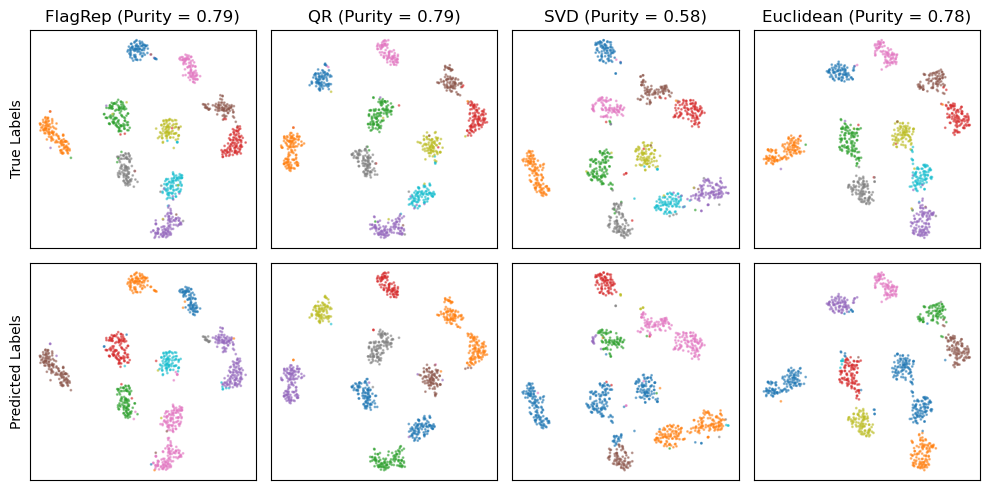

In [27]:

fig, ax = plt.subplots(2, 4, figsize = (10,5))
for a, row in zip(ax[:,0], ['True Labels', 'Predicted Labels']):
    a.set_ylabel(row, rotation=90)

for i, method_name in enumerate(['FlagRep', 'QR', 'SVD', 'Euclidean']):
    tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
    vis_data = tsne.fit_transform(dist_mats[method_name])

    scatter = ax[0,i].scatter(vis_data[:,0], vis_data[:,1], alpha=.5, c=mod_labels, cmap='tab10', s = 1)
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    

    n_clusters = 10  # Define the number of clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    cluster_labels = clustering.fit_predict(dist_mats[method_name])
    res = purity_score(mod_labels, cluster_labels)
    print(f'{method_name}:')
    print(f'Purity score: {res}')

    ax[1,i].scatter(vis_data[:,0], vis_data[:,1], alpha=.5, c=cluster_labels, cmap='tab10', s = 1)
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

    # ax[1,i].set_xlabel('t-SNE1')
    ax[0,i].set_title(f'{method_name} (Purity = {np.round(res,2)})')
plt.tight_layout()


/Users/natemankovich/Documents/PostDoc/FlagManifoldsV3/python/FlagRep.py:245: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


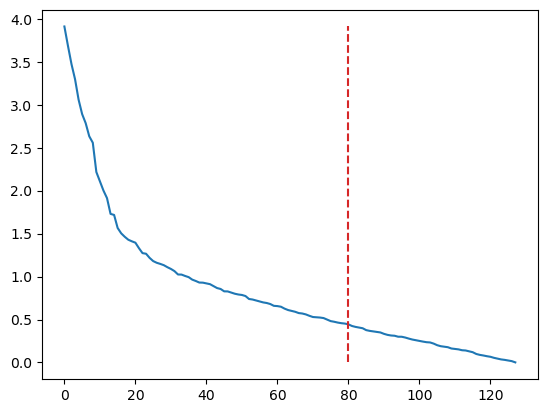

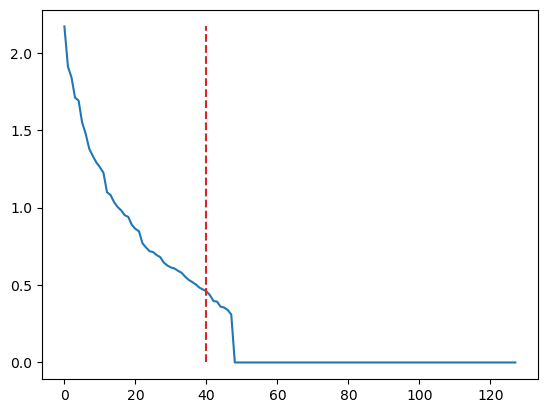

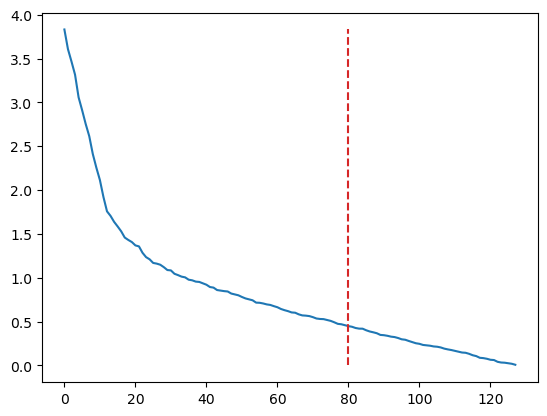

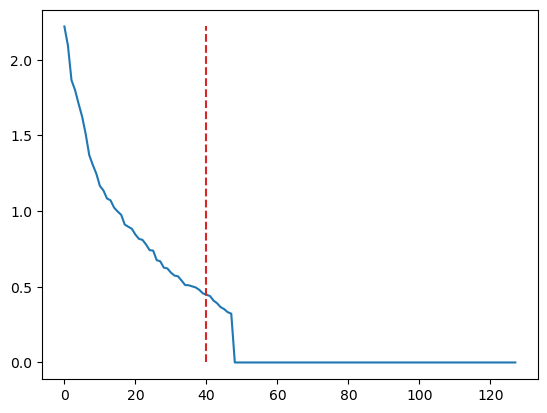

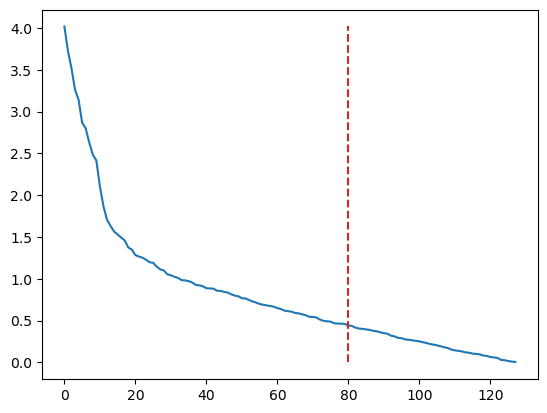

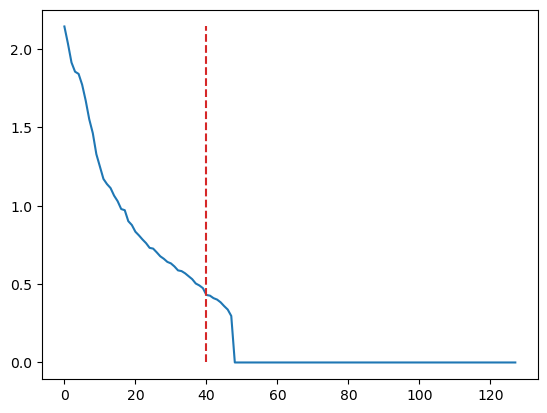

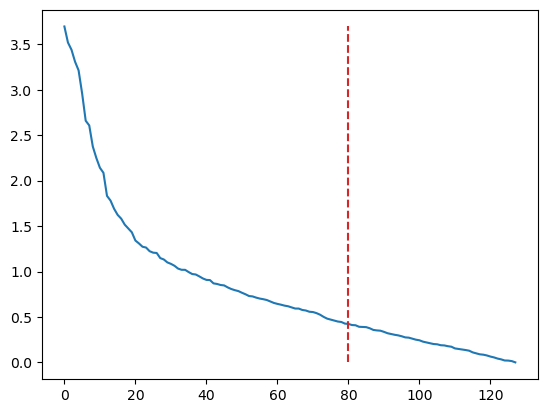

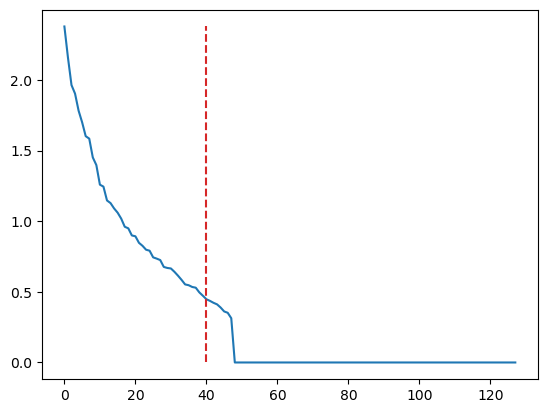

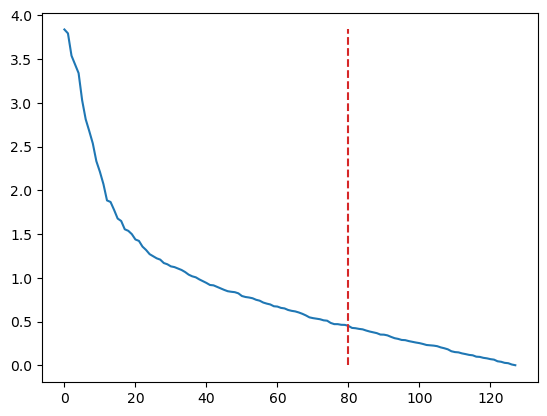

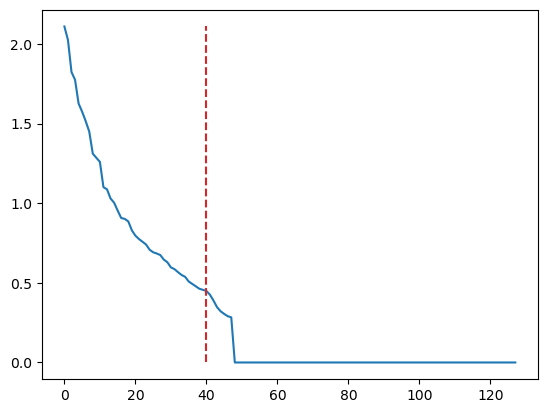

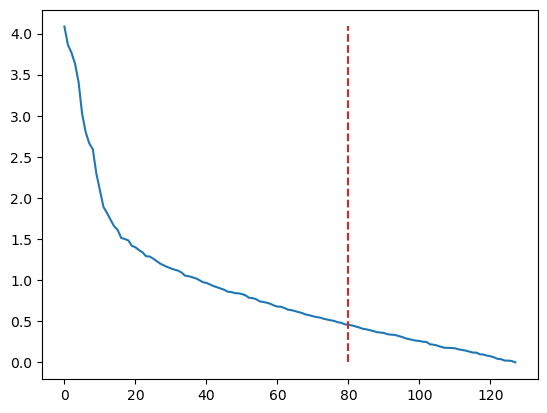

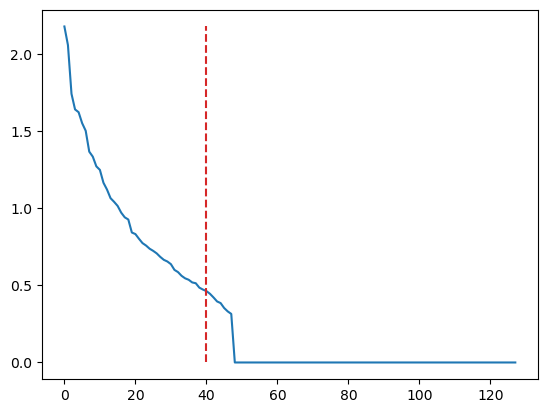

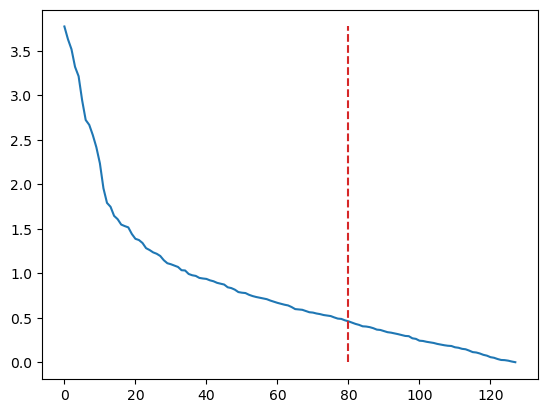

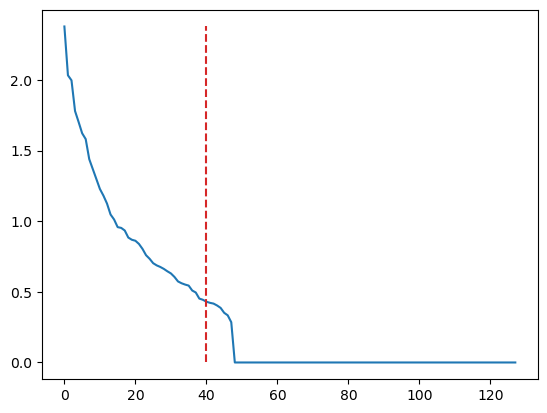

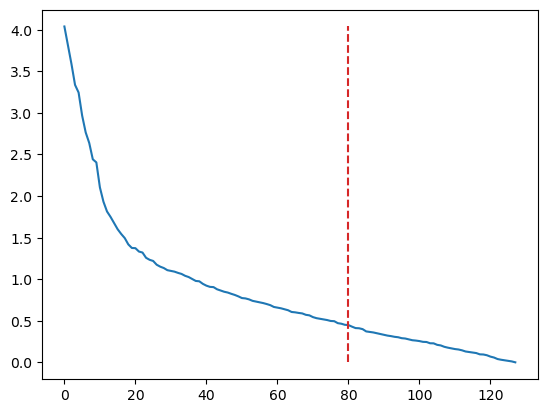

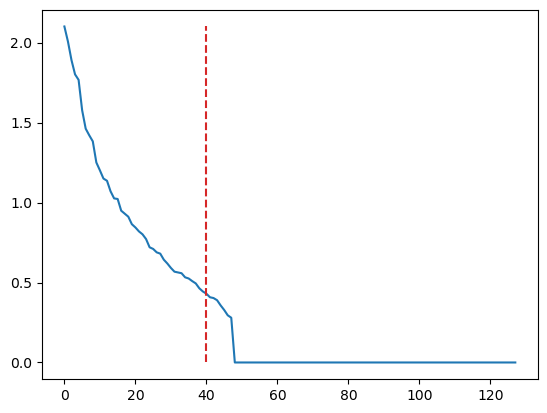

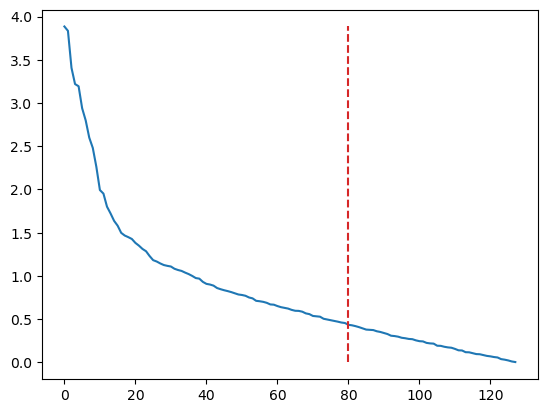

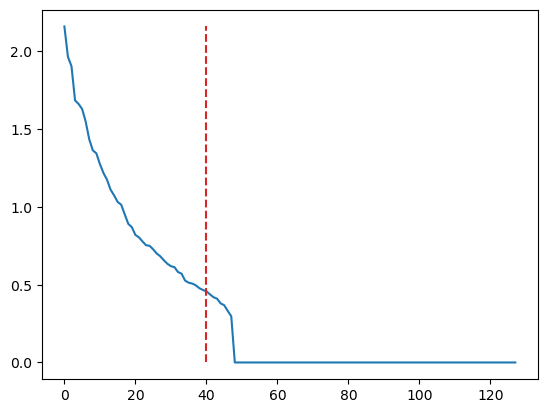

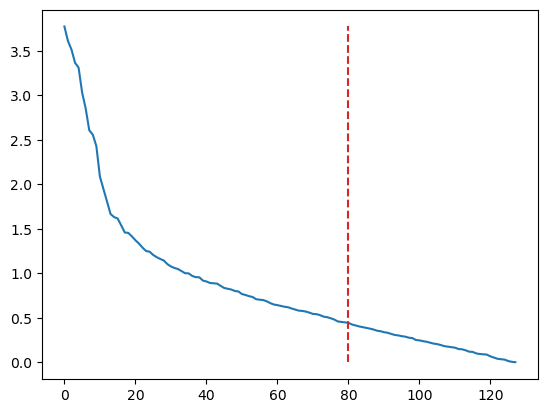

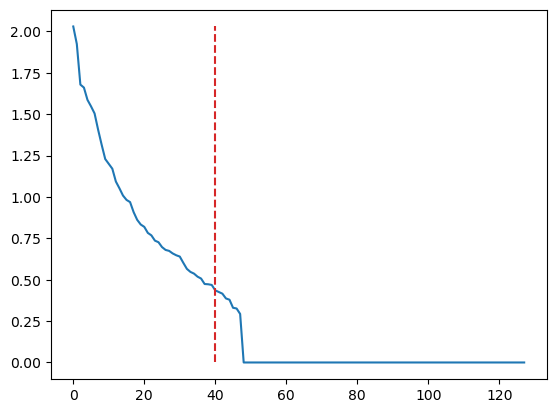

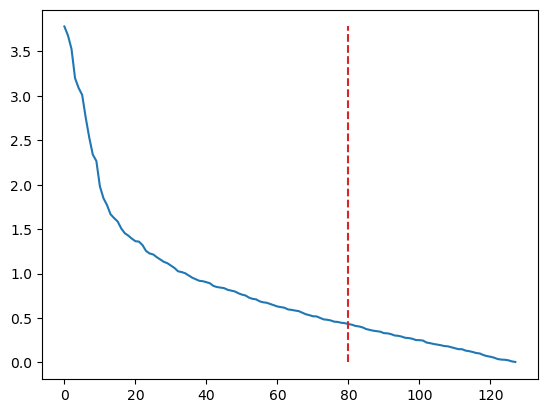

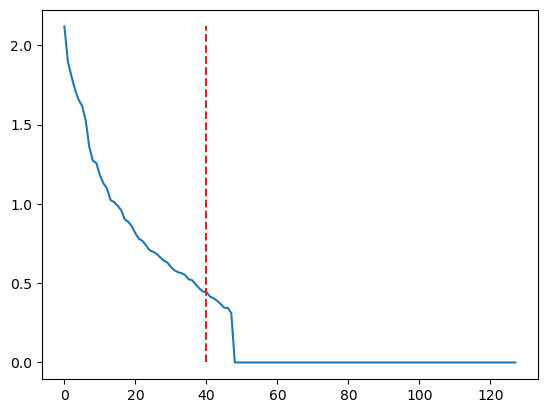

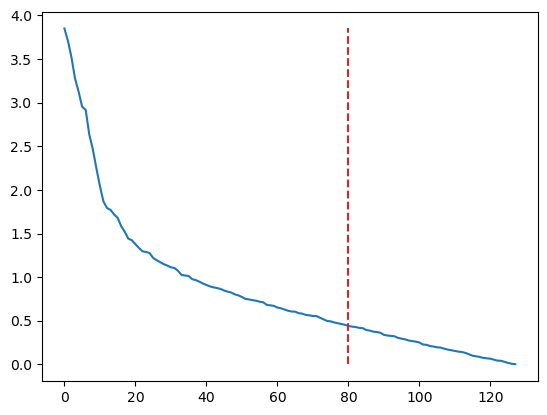

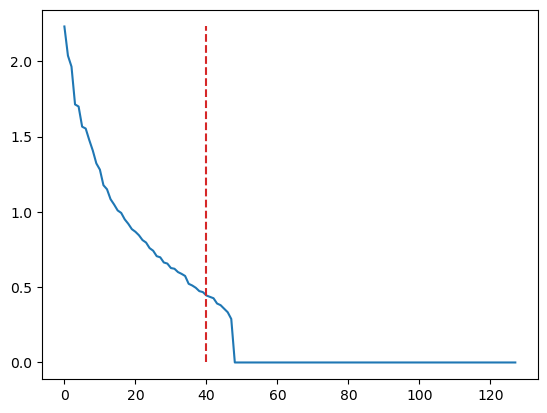

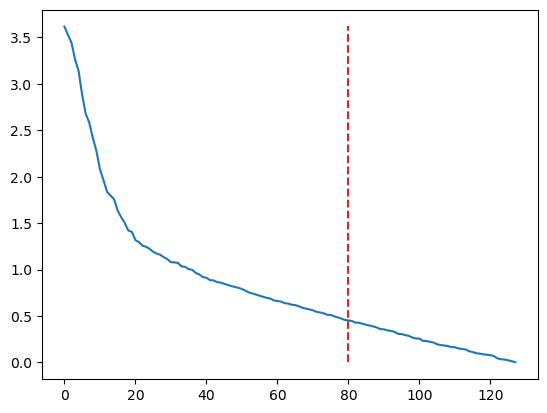

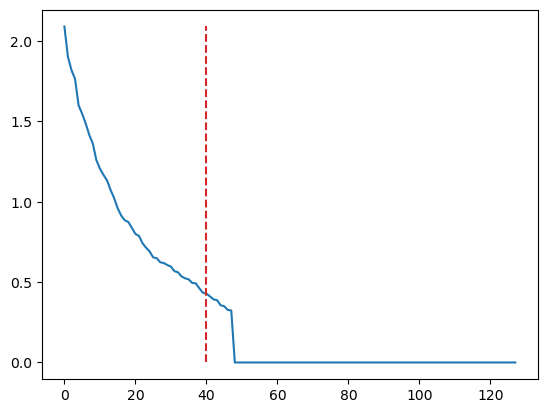

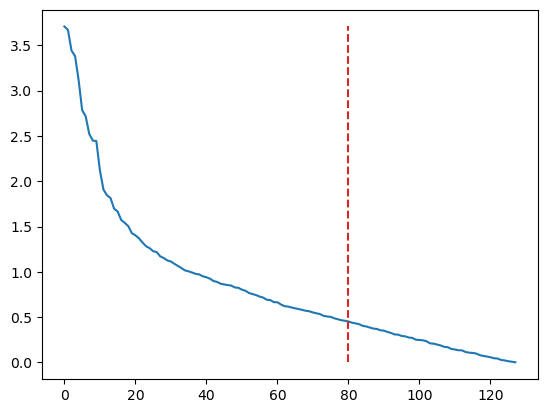

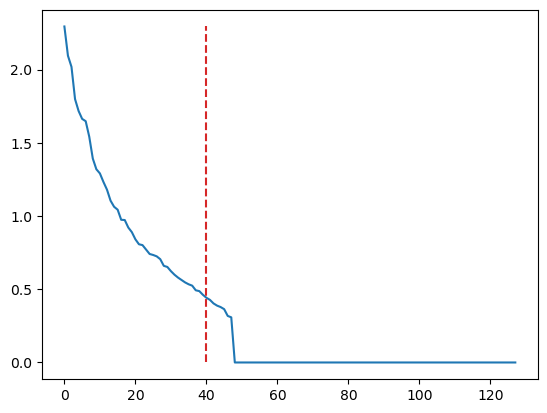

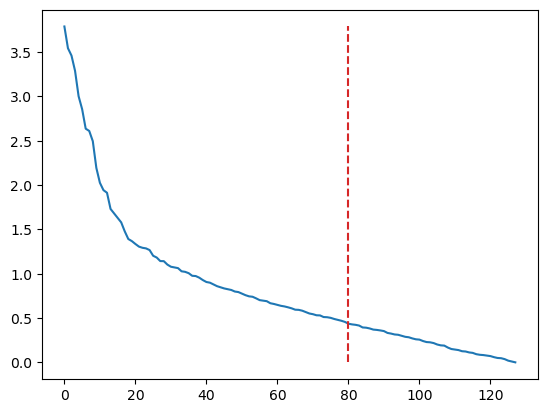

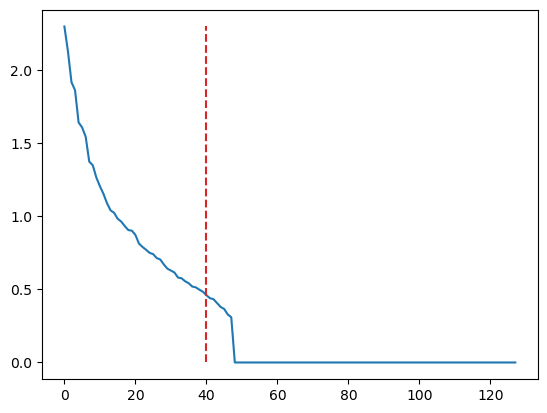

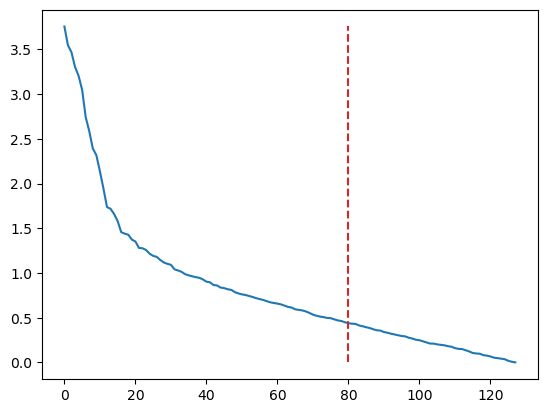

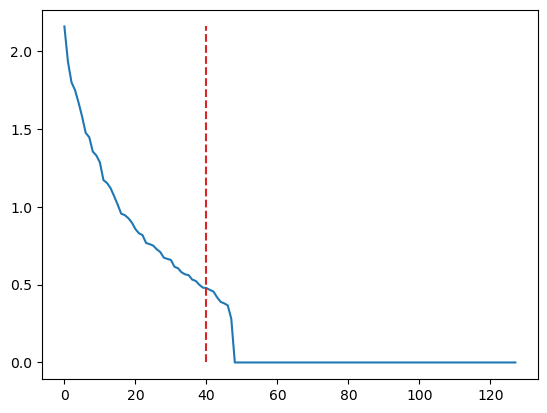

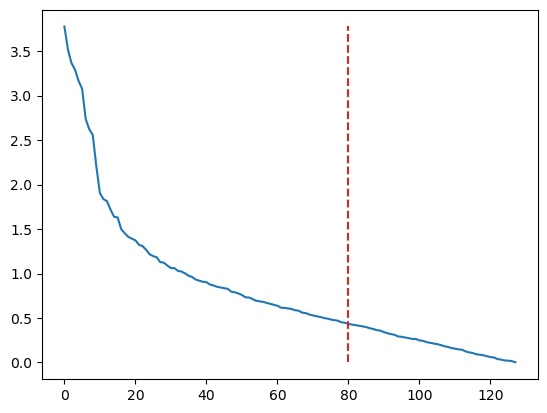

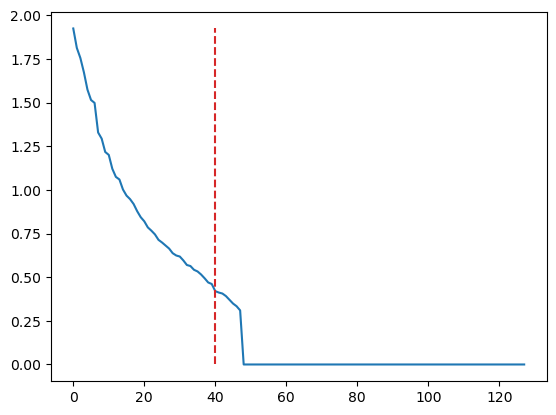

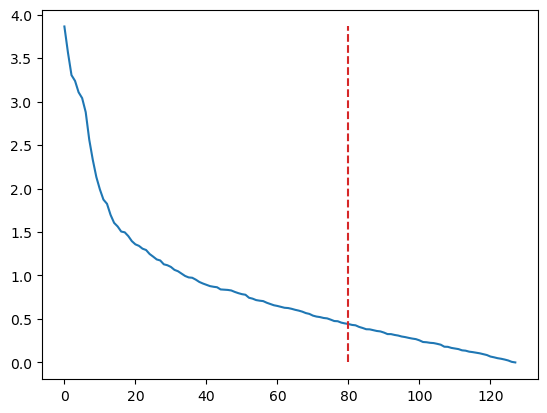

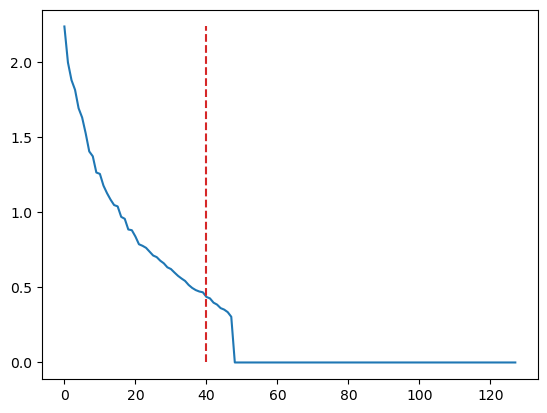

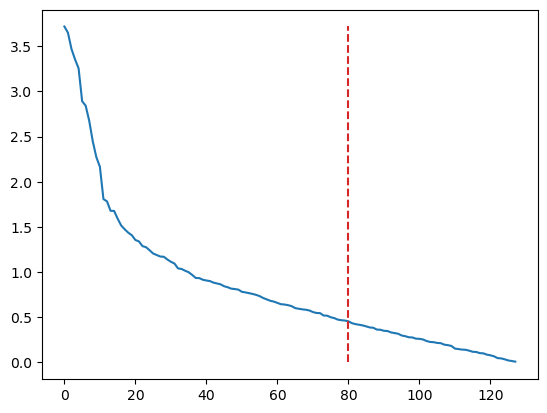

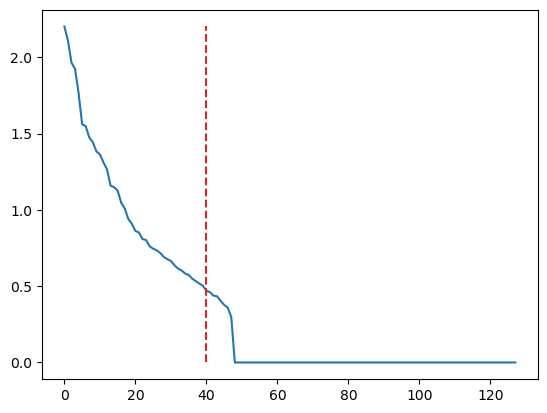

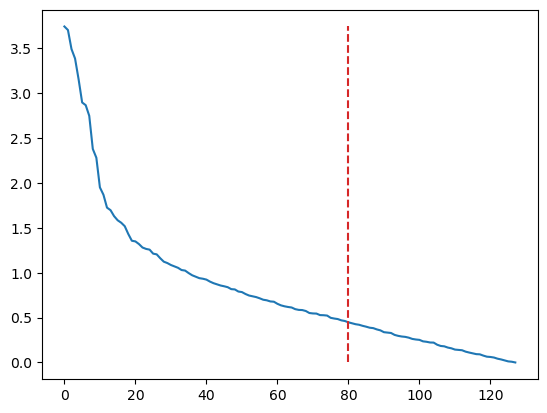

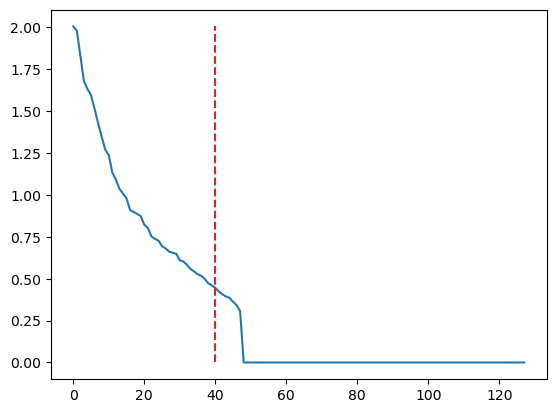

In [67]:
# Initialize the model, loss function, and optimizer
Xs = []
Rs = []
for i in range(20):
    model = NeuralNetwork(input_size, hidden_size, output_size)
    model.load_state_dict(torch.load(f'../models/mnist_model{i}.pth'))

    D = np.hstack([model.fc3.weight.detach().numpy(),model.fc2.weight.detach().numpy()])


    my_flag_rep = FlagRep(Aset = [np.arange(128), np.arange(128*2)], flag_type=[80,120], plot_eigs = True)
    X,R = my_flag_rep.decompose(D)

    Xs.append(X)
    Rs.append(R)


In [68]:
n_pts = len(Xs)
dist_mat = np.zeros((n_pts,n_pts))
for i in tqdm(range(n_pts)):
    for j in range(i+1,n_pts):
        x = Xs[i]
        y = Xs[j]
        Bs = make_Bs([80,120])
        dist = chordal_distance(x, y, Bs, Bs)
        
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist

100%|██████████| 20/20 [00:00<00:00, 85.34it/s]


array([[0.        , 0.98897845, 0.99026294, 0.98064706, 0.98486853,
        0.99069664, 0.98661064, 0.98530855, 0.98783563, 0.98677548,
        0.98892995, 0.98674818, 0.98549345, 0.99370451, 0.9843908 ,
        0.9948015 , 0.98415416, 0.99373701, 0.99066025, 0.99272179],
       [0.98897845, 0.        , 0.98727643, 0.9890556 , 0.98264726,
        0.98839496, 0.99419461, 0.98969882, 0.99038149, 0.98982603,
        0.98231355, 0.99034157, 0.99623192, 0.9964845 , 0.98902424,
        0.98839445, 0.98995449, 0.98683548, 0.99399478, 0.98998328],
       [0.99026294, 0.98727643, 0.        , 0.98106308, 0.98205923,
        0.99056438, 0.98909859, 0.98251463, 0.98890824, 0.99880802,
        0.9974176 , 0.98531359, 0.98667306, 0.98457809, 0.98687776,
        1.        , 0.99596539, 0.98106127, 0.98687933, 0.97901627],
       [0.98064706, 0.9890556 , 0.98106308, 0.        , 0.98391624,
        0.98572788, 0.98423584, 0.98901836, 0.98061107, 0.98906319,
        0.98766606, 0.99331362, 0.9881477 , 0

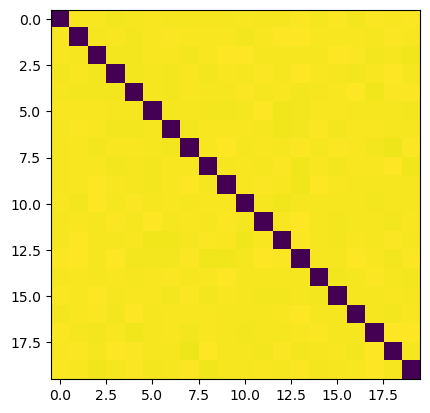

In [73]:
plt.imshow(dist_mat/dist_mat.max())
dist_mat/dist_mat.max()